# Three coils PSO Optimization from Article:
### Particle Swarm Optimization for Multiple Dipole
### Modeling of Space Equipment


## Yako Irusta Salles

In [18]:
# Installation of the PSO library used in this program

!git clone https://github.com/JoaquinAmatRodrigo/optimizacion_PSO_python.git
    
#Cloning into 'optimizacion_PSO_python'...    

fatal: destination path 'optimizacion_PSO_python' already exists and is not an empty directory.


In [19]:
import numpy as np
from numpy import random
import math 
import matplotlib.pyplot as plt

from PSO_python import Enjambre
from PSO_python import Particula

In [20]:
File_Data_2='./INPUT_READ_FILES/ThreeCoils_MagneticField_PSO-Article-Theta80_R500mm.txt'

In [21]:
#Lectura de los datos del fichero "File_Data"
R=np.loadtxt(File_Data_2, usecols=[0])
θ=np.loadtxt(File_Data_2, usecols=[1])
ϕ=np.loadtxt(File_Data_2, usecols=[2])

Bx_meas=np.loadtxt(File_Data_2, usecols=[3])
By_meas=np.loadtxt(File_Data_2, usecols=[4])
Bz_meas=np.loadtxt(File_Data_2, usecols=[5])

We need to find the position of the magnetometers in spherical coordinates so we calculate it with the following expressions:

$R=\sqrt{x^2+y^2+z^2}$

$\theta=arccos \left(\frac{z}{\sqrt{x^2+y^2+z^2}}\right)$

$\phi=arctan\left(\frac{y}{x}\right)$

In [22]:
X=R*np.sin(θ)*np.cos(ϕ)
Y=R*np.sin(θ)*np.sin(ϕ)
Z=R*np.cos(θ)

We need to definde the dipole approximation formula to calculate the magnetic field:

Comentar variables:

$\textbf{m}$: Magnetic moment vector with components $m_x$, $m_y$ and $m_z$.

$\textbf{r}$: Position vector modulus defined as $r=\sqrt{(x-x_0)^2+(y-y_0)^2+(z-z_0)^2}$.

$x_0$, $y_0$, $z_0$: Initial position of the dipole.
Units: 

$\left[ r \right]$=$m$

$\left[ m \right]$=$Am^2$


$\textbf{B}_x=\dfrac{\mu_0 }{4\pi}\left(\dfrac{3\left(m_x(x-x_0)+m_y(y-y_0)+m_z(z-z_0)\right)(x-x_0)}{r^5}-\dfrac{m_x}{r^3}\right) $

$\textbf{B}_y=\dfrac{\mu_0 }{4\pi}\left(\dfrac{3\left(m_x(x-x_0)+m_y(y-y_0)+m_z(z-z_0)\right)(y-y_0)}{r^5}-\dfrac{m_y}{r^3}\right) $

$\textbf{B}_z=\dfrac{\mu_0 }{4\pi}\left(\dfrac{3\left(m_x(x-x_0)+m_y(y-y_0)+m_z(z-z_0)\right)(z-z_0)}{r^5}-\dfrac{m_z}{r^3}\right) $

In [23]:
##############################################################################################################################

def Magnetic_Field(R,mx,my,mz,mR,x0,y0,z0):
    #IN:
        #R: Modulo del vector posicion
        #mx, my, mz: Momentos dipolares
    mu=4.0*math.pi*10**(-7.0)
    k=mu/(4.0*math.pi)
    
    Bx_PSO=-k*((mx/R**3)-((3.0*(X-x0)*mR)/R**5))
    By_PSO=-k*((my/R**3)-((3.0*(Y-y0)*mR)/R**5))
    Bz_PSO=-k*((mz/R**3)-((3.0*(Z-z0)*mR)/R**5))
    
    return Bx_PSO,By_PSO,Bz_PSO

We define the two fitness functions used in this program to optimize our values calculated with the PSO:

 -Fitness Function 1: 

$F_1=\dfrac{\sqrt{\sum_{i=0}^{M-1}\left[\left(B_{x}^{(meas)}\left[i\right]-B_{x}^{(PSO)}\left[i\right]\right)^2+\left(B_{y}^{(meas)}\left[i\right]-B_{y}^{(PSO)}\left[i\right]\right)^2+\left(B_{z}^{(meas)}\left[i\right]-B_{z}^{(PSO)}\left[i\right]\right)^2\right]}}{\sqrt{\sum_{i=0}^{M-1}\left[\left(B_{x}^{(meas)}\left[i\right]\right)^2+\left(B_{y}^{(meas)}\left[i\right]\right)^2+\left(B_{z}^{(meas)}\left[i\right]\right)^2\right]}}$

-Fitness Function 2: 

$F_2=\dfrac{\sum_{i=0}^{M-1}\left(B_{x}^{(meas)}\left[i\right]-B_{x}^{(PSO)}\left[i\right]\right)^2}{\sum_{i=0}^{M-1}\left(B_{x}^{(meas)}\left[i\right]\right)^2}+\dfrac{\sum_{i=0}^{M-1}\left(B_{y}^{(meas)}\left[i\right]-B_{y}^{(PSO)}\left[i\right]\right)^2}{\sum_{i=0}^{M-1}\left(B_{y}^{(meas)}\left[i\right]\right)^2}+\dfrac{\sum_{i=0}^{M-1}\left(B_{z}^{(meas)}\left[i\right]-B_{z}^{(PSO)}\left[i\right]\right)^2}{\sum_{i=0}^{M-1}\left(B_{z}^{(meas)}\left[i\right]\right)^2}$

-Fitness Function: 

$F^{(n)}=F_{2}^{(n)}\left(\dfrac{F_{2}^{(n-1)}}{F_{1}^{(n-1)}}\right)+F_{1}^{(n)}\left(\dfrac{F_{1}^{(n-1)}}{F_{2}^{(n-1)}}\right)$

In [24]:
##############################################################################################################################
############################################################################################################################
#FUNCTION: FitnessFunction1
# -) IN variables:
#    # -) Bx_PSO, By_PSO, Bz_PSO: Magnetic field calculated with the dipole approximation calculated with the function Magnetic_Field
#  
# -) OUT variables: 
#    # -) F1: Value of the fitness function 1 calculated with the function shown
############################################################################################################################
def FitnessFunction_F1(Bx_PSO,By_PSO,Bz_PSO):
    
    length=len(Bx_meas)-1    
    sum_num_B=0.0
    sum_den_B=0.0
    
    for i in range(0,length):
        sum_num_B=sum_num_B+((Bx_meas[i]-Bx_PSO[i])**2.0+(By_meas[i]-By_PSO[i])**2.0+(Bz_meas[i]-Bz_PSO[i])**2.0)
        sum_den_B=sum_den_B+(Bx_meas[i]**2.0+By_meas[i]**2.0+Bz_meas[i]**2.0)
    
    F1=np.sqrt(sum_num_B/sum_den_B)
    
    return F1

In [25]:
##############################################################################################################################
############################################################################################################################
#FUNCTION: FitnessFunction2
# -) IN variables:
#    # -) Bx_PSO, By_PSO, Bz_PSO: Magnetic field calculated with the dipole approximation calculated with the function Magnetic_Field
#  
# -) OUT variables: 
#    # -) F1: Value of the fitness function 2 calculated with the function shown
############################################################################################################################
def FitnessFunction_F2(Bx_PSO,By_PSO,Bz_PSO):
    
    length=len(Bx_meas)-1
    sum_num_Bx=0.0
    sum_num_By=0.0
    sum_num_Bz=0.0
    sum_den_Bx=0.0
    sum_den_By=0.0
    sum_den_Bz=0.0

    for i in range(0,length):
        sum_num_Bx=sum_num_Bx+(Bx_meas[i]-Bx_PSO[i])**2.0
        sum_num_By=sum_num_By+(By_meas[i]-By_PSO[i])**2.0
        sum_num_By=sum_num_By+(Bz_meas[i]-Bz_PSO[i])**2.0
        
        sum_den_Bx=sum_den_Bx+(Bx_meas[i])**2.0
        sum_den_By=sum_den_By+(By_meas[i])**2.0
        sum_den_Bz=sum_den_Bz+(Bz_meas[i])**2.0
        
    xnum_Bx=sum_num_Bx/sum_den_Bx
    xnum_By=sum_num_By/sum_den_By
    xnum_Bz=sum_num_Bz/sum_den_Bz    
        
    F2=xnum_Bx+xnum_By+xnum_Bz
    
    return F2

In [26]:
##############################################################################################################################
############################################################################################################################
#FUNCTION: FitnessFunction_Ini
# -) IN variables:
#    # -) x0, y0, z0: Position components calculated with the PSO algorithm.
#    # -) mx, my, mz: Magnetic moments calculated with the PSO algorithm.
#
# -) OUT variables: 
#    # -) F: Initial fitness function value calculated with the function shown to initialize the value.
############################################################################################################################
def FitnessFunction_Ini(x0,y0,z0,mx,my,mz):
    
    global F1_0
    global F2_0
    
    F1_0=random.rand()
    F2_0=random.rand()
    
    R=np.sqrt((X-x0)**2+(Y-y0)**2+(Z-z0)**2)  
    mR=mx*(X-x0)+my*(Y-y0)+mz*(Z-z0)

    #Componentes vectoriales Bx, By, Bz de campo magnetico generado por la bobina 1    
    Bx,By,Bz=Magnetic_Field(R,mx,my,mz,mR,x0,y0,z0)
    
    F1=FitnessFunction_F1(Bx,By,Bz)
    F2=FitnessFunction_F2(Bx,By,Bz)
    F=F2*(F2_0/F1_0)+F1*(F1_0/F2_0)
    
    return F1

In [27]:
##############################################################################################################################
############################################################################################################################
#FUNCTION: FitnessFunction
# -) IN variables:
#    # -) x0, y0, z0: Position components calculated with the PSO algorithm.
#    # -) mx, my, mz: Magnetic moments calculated with the PSO algorithm.
#
# -) OUT variables: 
#    # -) F: Fitness function value used to fit our values calculated with the PSO to the measured values.
############################################################################################################################
def FitnessFunction(x0,y0,z0,mx,my,mz):
    
    global F1_0
    global F2_0
    
    R=np.sqrt((X-x0)**2+(Y-y0)**2+(Z-z0)**2)  
    mR=mx*(X-x0)+my*(Y-y0)+mz*(Z-z0)

    #Componentes vectoriales Bx, By, Bz de campo magnetico generado por la bobina 1    
    Bx,By,Bz=Magnetic_Field(R,mx,my,mz,mR,x0,y0,z0)
    
    F1=FitnessFunction_F1(Bx,By,Bz)
    F2=FitnessFunction_F2(Bx,By,Bz)
    
    F=F2*(F2_0/F1_0)+F1*(F1_0/F2_0)
    F2_0=F2
    F1_0=F1

    return F1

In [28]:
#Definition of the swarm used in this program
#SWARM Properties: 
#   # -) Number of particles: 32
#   # -) Number of variables: 6(3 position varibles[x,y,z] and 3 magnetic moment varibles[mx,my,mz])
#   # -) Lower limit of the variables: [-15,-15,-15(position limits),-800,-800,-800(magnetic moment limits)]
#   # -) Upper limit of the variables: [15,15,15(position limits),800,800,800(magnetic moment limits)]
swarm=Enjambre(
    n_particulas = 32,
    n_variables  = 6,
    limites_inf  = [-15,-15,-15,-800,-800,-800],
    limites_sup  = [15,15,15,800,800,800],
    verbose      = False
    )

In [29]:
#We evaluate our swarm created to determine the initial value for the fitness function .
#Optimization: Find minimum value.
swarm.evaluar_enjambre(
    funcion_objetivo=FitnessFunction_Ini,
    optimizacion="minimizar",
    verbose=False
)

In [32]:
#Optimization of our swarm.
#Optimization properties: 
#   # -) Function to fit: FitnessFunction.
#   # -) Optimization: Find minimum.
#   # -) Number of itinerations: 500
#   # -) Tolerance: 10**(-8)
swarm.optimizar(
    funcion_objetivo  = FitnessFunction,
    optimizacion      = "minimizar",
    n_iteraciones     = 500,
    inercia           = 1.0,
    reduc_inercia     = True,
    inercia_max       = 1.0,
    inercia_min       = 0.6,
    peso_cognitivo    = 1.5,
    peso_social       = 1.5,
    parada_temprana   = True,
    rondas_parada     = 5,
    tolerancia_parada = 10**-8,
    verbose           = False   
)
#Program running duration estimate: 230s

-------------------------------------------
Optimización finalizada 2021-06-13 22:59:47
-------------------------------------------
Duración optimización: 19.69967031478882
Número de iteraciones: 499
Posición óptima: [0.08002089497641354 2.4399287797047906e-05 0.4799671731490812
 158.3707089320713 -211.2073171861465 166.43966594899794]
Valor óptimo: 0.002349091215076864



<AxesSubplot:xlabel='Itineration', ylabel='Fitness Function'>

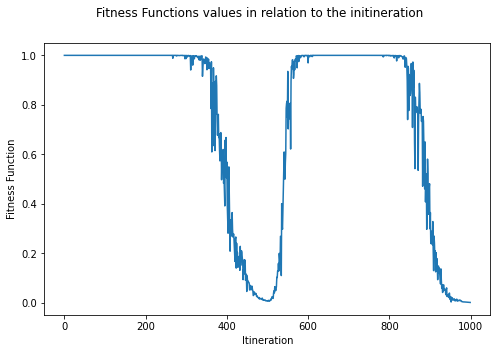

In [33]:
#Plot of the fitness values obtained during the compilation of the program
#X label: Number of itinerations
#Y Label: Fitness values 
figure_fitness_values=plt.figure(figsize=(8,5))
plt.grid()
plt.xlabel('Itineration')
plt.ylabel('Fitness Function')
figure_fitness_values.suptitle('Fitness Functions values in relation to the initineration')
swarm.resultados_df['mejor_valor_enjambre'].plot()